In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import requests
import time
import random
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

##Dimension reduction techniques
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA, KernelPCA
import umap

##Supervised Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##Deep learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

%matplotlib inline
from datetime import datetime
import seaborn as sns

from scipy import stats, special

In [2]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

In [3]:
Year_list = ['2022']
Month_list = ['July', 'August', 'September', 'October', 'November', 'December']

##This is a dictionary that stores the original data everymonth
original_data = dict()

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()

##This is a dictionary that store datasets to run analysis
monthly_data_dict2 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

##Remove zipcode, city, county, SchoolDistrict since longitude and latitude will do the part

for Year in Year_list:
    for Month in Month_list:
        main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
        cols = main_df.columns.tolist()
        
        ##Rename some columns
        for c in cols:
            if 'resoFacts.' in c:
                feature = c.split('.')[1]
                main_df[feature] = main_df[c]
                main_df.drop(labels = [c], axis = 1, inplace = True)
                
        ##Drop unimportant features 
        main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
        main_df.reset_index(drop = True, inplace = True)
        
        ##Join the categorical dataframes
        for category in Selected_features:
            ft = category.split('.')[1]
            name = 'houses' + '_' + ft + '.csv'
            df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
            main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')
        
        string_list = ['city', 'county', 'SchoolDistrict', 'levels']
        for string in string_list:
            main_df[string] = main_df[string].str.lower()
        original_data[Month + '_' + Year] = main_df
        
        main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
        monthly_data_dict1[Month + '_' + Year] = main_df
        
        remove_features = ['zipcode', 'city', 'county', 'SchoolDistrict', 'annualHomeownersInsurance']
        main_df2 = main_df.copy()
        main_df2.drop(labels = remove_features, axis = 1, inplace = True)
        monthly_data_dict2[Month + '_' + Year] = main_df2

In [4]:
category_list = ['isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 'canRaiseHorses', 'hasGarage', 
                 'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 
                 'levels', 'isNewConstruction']

numerical_list = ['monthlyHoaFee', 'livingAreaValue', 'bedrooms', 'longitude', 'latitude',
                  'mortgageRates.fifteenYearFixedRate', 'mortgageRates.thirtyYearFixedRate', 'mortgageRates.arm5Rate', 
                  'propertyTaxRate', 'price', 'Crime_per_1000', 'carportSpaces', 'garageSpaces', 'parking', 'coveredSpaces',
                  'bathrooms', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']

In [5]:
def transform_data(main_df, category_list):
    df_transformed = main_df.copy()
    for cat in category_list:
        all_values = df_transformed[cat].unique()
        if (len(all_values) == 2) and (True in all_values) and (False in all_values):
            df_transformed.loc[df_transformed[cat] == True, cat] = 1
            df_transformed.loc[df_transformed[cat] == False, cat] = 0
        elif len(all_values) > 2:
            new_ft = pd.get_dummies(df_transformed[cat], prefix = cat)
            df_transformed = pd.concat([df_transformed, new_ft], axis = 1)
            df_transformed.drop(labels = [cat], axis = 1, inplace = True)
    
    all_cols = df_transformed.columns.tolist()
    encoded_categories = sorted(set(all_cols) - set(numerical_list))
    n_list = sorted(set(numerical_list) - set(['price']))
    all_features = encoded_categories + n_list
    
    df_transformed = df_transformed[all_features + ['price']]
    ##we want to keep the list of features in order
    return all_features, df_transformed

In [6]:
def equally_scaled_data(df_transformed, numerical_list):
    df_scaled = df_transformed.copy()
    n_list = sorted(set(numerical_list) - set(['price']))
    for num_ft in n_list:
        col = df_scaled[num_ft].to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler()
        col_transformed = scaler.fit_transform(col)
        df_scaled[num_ft] = col_transformed
    return df_scaled

def unequal_scaled_data(df_transformed, numerical_list, favored_num, feature_range_wide):
    df_scaled = df_transformed.copy()
    n_list = sorted(set(numerical_list) - set(['price']))
    for num_ft in n_list:
        col = df_scaled[num_ft].to_numpy().reshape(-1, 1)
        if num_ft in favored_num:
            scaler1 = MinMaxScaler(feature_range_wide)
            col_transformed = scaler1.fit_transform(col)
            df_scaled[num_ft] = col_transformed
        else:
            scaler2 = MinMaxScaler(feature_range = (0, 1))
            col_transformed = scaler2.fit_transform(col)
            df_scaled[num_ft] = col_transformed
    return df_scaled

In [7]:
transformed_df_dict = dict()
transformed_features_dict = dict()
equal_scale_dict = dict()
unequal_scale_dict = dict()

feature_range_wide = (10, 25)
favored_num = ['monthlyHoaFee', 'livingAreaValue', 'bedrooms', 'longitude', 'latitude', 'mortgageRates.fifteenYearFixedRate', 
               'mortgageRates.fifteenYearFixedRate', 'garageSpaces', 'parking', 'coveredSpaces', 'bathrooms', 
               'bathroomsHalf', 'bathroomsFull', 'fireplaces']

for Year in Year_list:
    for Month in Month_list:
        df_original = monthly_data_dict2[Month + '_' + Year]
        all_features, df_transformed = transform_data(df_original, category_list)
        transformed_features_dict[Month + '_' + Year] = all_features
        transformed_df_dict[Month + '_' + Year] = df_transformed
        
        equal_scale_df = equally_scaled_data(df_transformed, numerical_list)
        unequal_scale_df = unequal_scaled_data(df_transformed, numerical_list, favored_num, feature_range_wide)
        equal_scale_dict[Month + '_' + Year] = equal_scale_df
        unequal_scale_dict[Month + '_' + Year] = unequal_scale_df

In [8]:
def embedding_data(X, target, technique, n_dimensions):
    projections = technique.fit_transform(X)
    dims = list()
    for i in range(n_dimensions):
        dims.append('x' + str(i+1))
    proj_df = pd.DataFrame(data = projections, columns = dims)
    proj_df['price'] = target
    return proj_df

def plot_2D_embedding_heatmap(projections_equal, projections_unequal, name, month):
    fig, ax = plt.subplots(1, 2, figsize = (15,7))
    st = fig.suptitle("House data 2D embedding with prices (in $k) as heatmap " + '(' + month + ')', 
                      horizontalalignment='center', verticalalignment='top', fontsize="x-large")
    
    cm = plt.cm.get_cmap('inferno')
    x1e = projections_equal['x1'].to_numpy()
    x2e = projections_equal['x2'].to_numpy()
    x1u = projections_unequal['x1'].to_numpy()
    x2u = projections_unequal['x2'].to_numpy()
    z =  projections_equal['price'].to_numpy()/1000
    
    ax0 = ax[0].scatter(x1e, x2e, c = z, vmin = 200, vmax = 800, s = 18, cmap = cm, alpha = 0.6)
    ax1 = ax[1].scatter(x1u, x2u, c = z, vmin = 200, vmax = 800, s = 18, cmap = cm, alpha = 0.6)
    ax[0].set_title(name + " 2D embedding of data (equally scaled features)")
    ax[1].set_title(name + " 2D embedding of data (unequally scaled features)")
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[1].set(xlabel = None, ylabel = None)
    plt.colorbar(ax0)
    plt.colorbar(ax1)
    fig.tight_layout()
    st.set_y(0.95)
    st.set_x(0.49)
    fig.subplots_adjust(top=0.85)
    plt.show()

#### We will only use these features since they are consistent throughout the datasets

In [9]:
features_t = ['hasAssociation', 'hasAttachedGarage', 'hasCarport', 'hasFireplace', 'hasGarage', 'hasPrivatePool',
              'hasSpa', 'isNewConstruction', 'isSeniorCommunity', 'levels_multi/split', 'levels_one', 
              'levels_one and one half', 'levels_two', 'levels_three or more', 'bathrooms', 'bathroomsFull',
              'bathroomsHalf', 'bedrooms', 'carportSpaces', 'coveredSpaces', 'fireplaces', 'garageSpaces',
              'latitude', 'longitude', 'livingAreaValue', 'monthlyHoaFee', 'mortgageRates.arm5Rate',
              'mortgageRates.fifteenYearFixedRate', 'mortgageRates.thirtyYearFixedRate', 'parking',
              'propertyTaxRate', 'price']

In [10]:
tsne_2d = TSNE(n_components = 2, perplexity = 100, random_state = 0, learning_rate = 'auto', n_iter = 500)
pca_2d = PCA(n_components = 2, random_state = 0)
kernel_pca_2d = KernelPCA(n_components = 2, kernel = 'rbf', random_state = 0)
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
spectral_2d_rbf = SpectralEmbedding(n_components=2, affinity = 'rbf', random_state=0)

In [11]:
df_Sept = transformed_df_dict['September_2022'][features_t]

In [12]:
df_Sept

,hasAssociation,hasAttachedGarage,hasCarport,hasFireplace,hasGarage,hasPrivatePool,hasSpa,isNewConstruction,isSeniorCommunity,levels_multi/split,...,latitude,longitude,livingAreaValue,monthlyHoaFee,mortgageRates.arm5Rate,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,parking,propertyTaxRate,price
0,0,0,1,0,0,0,0,0,0,0,...,33.293644,-97.789510,748.0,0.0,5.562,5.639,6.470,4,1.47,179900
1,0,0,0,0,0,0,0,0,0,0,...,33.296837,-97.798600,1425.0,0.0,5.562,5.639,6.470,0,1.47,189000
2,0,0,1,0,0,0,0,0,0,0,...,33.292850,-97.796005,1416.0,0.0,5.562,5.639,6.470,2,1.47,195000
3,0,0,0,0,0,0,0,0,0,0,...,33.210660,-97.748680,820.0,0.0,5.562,5.639,6.470,0,1.47,148000
4,0,0,0,0,0,0,0,0,0,0,...,33.239480,-97.584170,1296.0,0.0,5.562,5.639,6.470,0,1.47,199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12673,0,1,0,1,1,1,0,0,0,0,...,32.228120,-96.857666,4601.0,0.0,5.653,5.978,6.143,3,1.86,1250000
12674,0,1,1,1,1,1,1,0,0,0,...,32.297650,-97.042015,3659.0,0.0,5.653,5.978,6.143,3,1.86,1950000
12675,0,0,0,0,1,0,0,0,0,0,...,32.359640,-96.832670,2584.0,0.0,5.653,5.978,6.143,0,1.86,899000
12676,0,1,0,1,1,0,0,0,0,0,...,32.342957,-96.945750,2826.0,0.0,5.653,5.978,6.143,2,1.86,1350000


In [13]:
X_equal = equal_scale_dict['September_2022'][features_t].iloc[:, :-1].to_numpy()
X_unequal = unequal_scale_dict['September_2022'][features_t].iloc[:, :-1]
target = equal_scale_dict['September_2022']['price']
target

0         179900
1         189000
2         195000
3         148000
4         199000
          ...   
12673    1250000
12674    1950000
12675     899000
12676    1350000
12677     899900
Name: price, Length: 12678, dtype: int64

### TSNE

C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


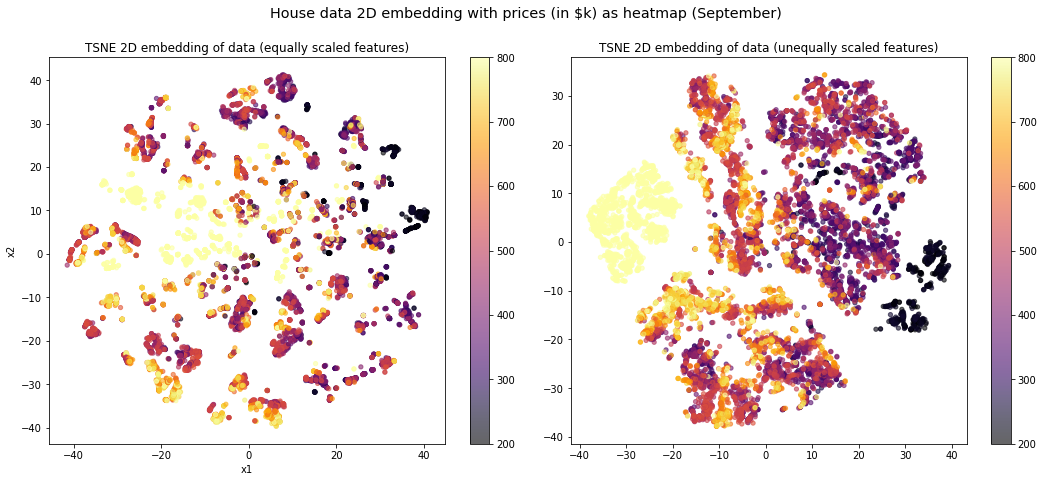

In [14]:
projections_equal_tsne_2d = embedding_data(X_equal, target, tsne_2d, 2)
projections_unequal_tsne_2d = embedding_data(X_unequal, target, tsne_2d, 2)
plot_2D_embedding_heatmap(projections_equal_tsne_2d, projections_unequal_tsne_2d, 'TSNE', 'September')

### PCA

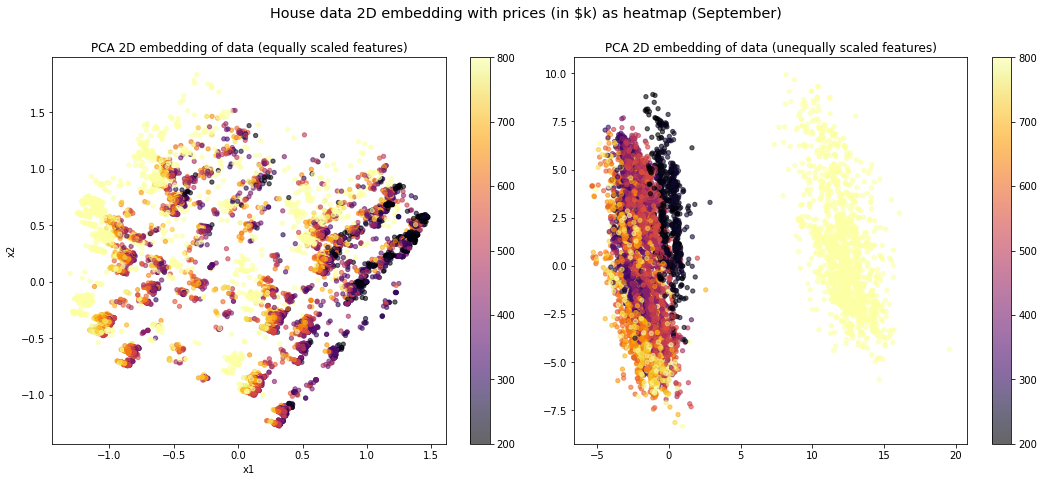

In [15]:
projections_equal_pca_2d = embedding_data(X_equal, target, pca_2d, 2)
projections_unequal_pca_2d = embedding_data(X_unequal, target, pca_2d, 2)
plot_2D_embedding_heatmap(projections_equal_pca_2d, projections_unequal_pca_2d, 'PCA', 'September')

### Kernel PCA

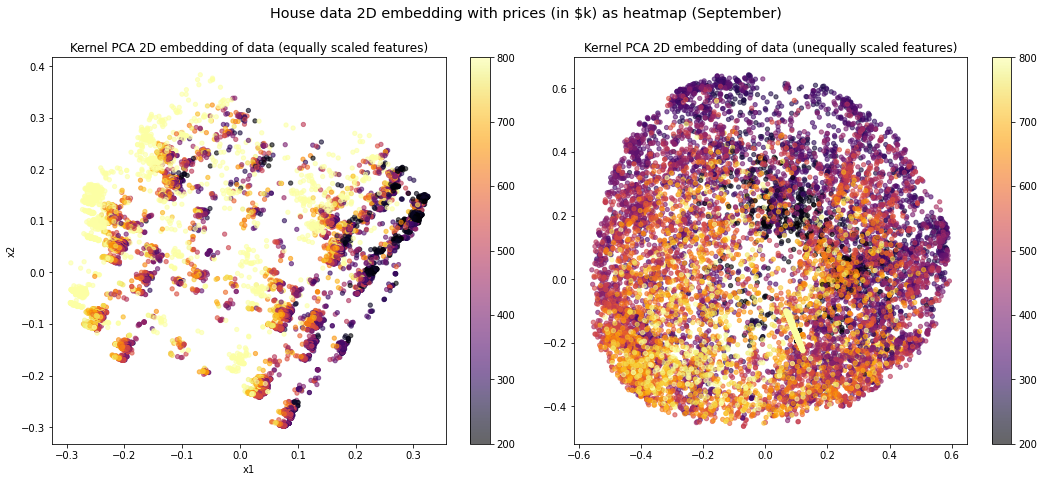

In [16]:
projections_equal_kernel_pca_2d = embedding_data(X_equal, target, kernel_pca_2d, 2)
projections_unequal_kernel_pca_2d = embedding_data(X_unequal, target, kernel_pca_2d, 2)
plot_2D_embedding_heatmap(projections_equal_kernel_pca_2d, projections_unequal_kernel_pca_2d, 'Kernel PCA', 'September')

### Umap

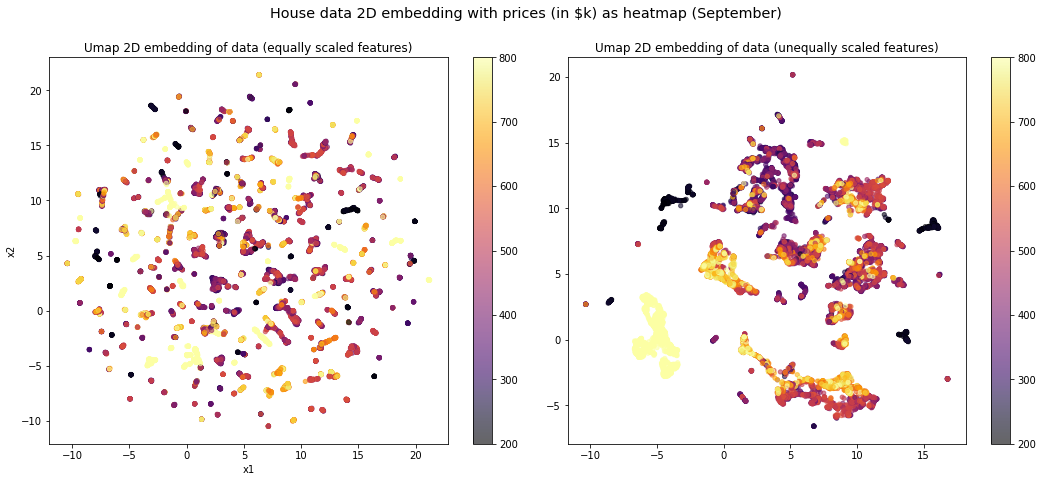

In [17]:
projections_equal_umap_2d = embedding_data(X_equal, target, umap_2d, 2)
projections_unequal_umap_2d = embedding_data(X_unequal, target, umap_2d, 2)
plot_2D_embedding_heatmap(projections_equal_umap_2d, projections_unequal_umap_2d, 'Umap', 'September')

### Spectral

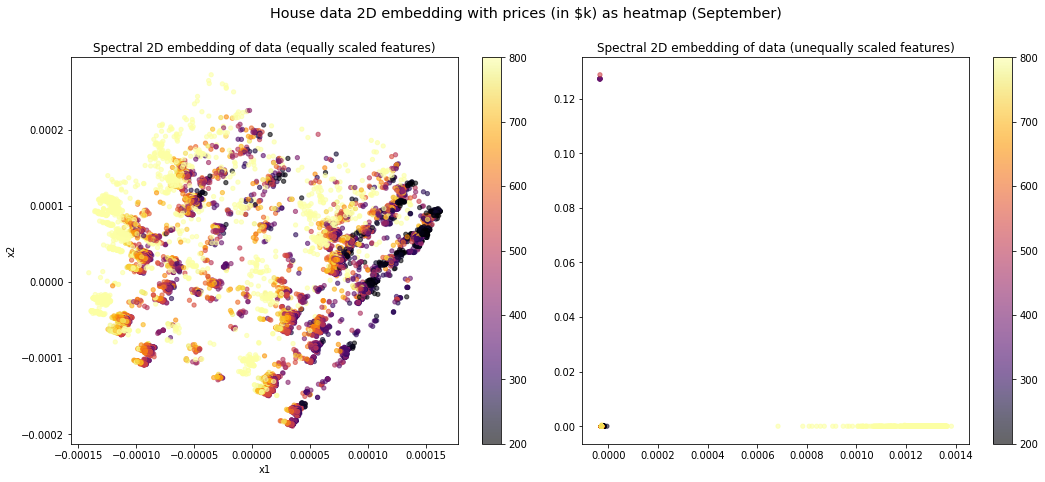

In [18]:
projections_equal_spectral_2d = embedding_data(X_equal, target, spectral_2d_rbf, 2)
projections_unequal_spectral_2d = embedding_data(X_unequal, target, spectral_2d_rbf, 2)
plot_2D_embedding_heatmap(projections_equal_spectral_2d, projections_unequal_spectral_2d, 'Spectral', 'September')

### Measure how good the graphs look

In [12]:
def cross_validation(model, projections, n_dimensions, target, cv, metrics):
    data = projections.iloc[:, :n_dimensions].to_numpy()
    results = cross_validate(estimator = model, X = data, y = target, cv = cv,
                             scoring = metrics, return_train_score = True)
    return results

In [20]:
equal_features_proj = [projections_equal_tsne_2d, projections_equal_pca_2d, projections_equal_kernel_pca_2d, 
                      projections_equal_spectral_2d, projections_equal_umap_2d]

unequal_features_proj = [projections_unequal_tsne_2d, projections_unequal_pca_2d, projections_unequal_kernel_pca_2d, 
                         projections_unequal_spectral_2d, projections_unequal_umap_2d]

In [21]:
def table_results(projections_list, n_dimensions, cv, technique, metrics_regression):
    m = len(projections_list)
    results_array = np.zeros((6, m))
    for i in range(m):
        target = projections_list[i]['price'].to_numpy()
        results = cross_validation(technique, projections_list[i], n_dimensions, 
                                   target, cv, metrics_regression)
        train_r2_mean = np.round(results['train_r2'].mean(), 4)
        test_r2_mean = np.round(results['test_r2'].mean(), 4)
        train_rmse_mean = np.round((results['train_neg_root_mean_squared_error'] * -1).mean(), 4)
        test_rmse_mean = np.round((results['test_neg_root_mean_squared_error'] * -1).mean(), 4)
        train_mae_mean = np.round((results['train_neg_mean_absolute_error'] * -1).mean(), 4)
        test_mae_mean = np.round((results['test_neg_mean_absolute_error'] * -1).mean(), 4)
        
        ##Fill in the results table
        results_array[0][i] = train_r2_mean
        results_array[1][i] = test_r2_mean
        results_array[2][i] = train_rmse_mean
        results_array[3][i] = test_rmse_mean
        results_array[4][i] = train_mae_mean
        results_array[5][i] = test_mae_mean
    results_df = pd.DataFrame(results_array, index = ['train_r2_mean', 'test_r2_mean', 'train_rmse_mean', 
                                                      'test_rmse_mean', 'train_mae_mean', 'test_mae_mean'], 
                              columns = ['TSNE', 'PCA', 'KERNEL PCA', 'SPECTRAL', 'UMAP'])
    return results_df

In [22]:
KNN_r = KNeighborsRegressor(n_neighbors = 55)
n_dimensions = 2
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']

equal_scale = table_results(equal_features_proj, n_dimensions, cv, KNN_r, metrics_regression)
equal_scale

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
train_r2_mean,0.7175,0.6474,0.6487,0.6428,0.6153
test_r2_mean,0.7052,0.6321,0.6335,0.6280,0.5990
train_rmse_mean,154423.4059,172522.1672,172200.0483,173652.2300,180195.9236
test_rmse_mean,157662.0767,176153.8381,175805.0512,177114.0399,183861.2475
train_mae_mean,95160.8217,102196.2578,101897.6287,102971.3625,115664.0264
test_mae_mean,97257.4922,104433.8032,104096.5551,105141.9915,118178.1521


In [23]:
unequal_scale = table_results(unequal_features_proj, n_dimensions, cv, KNN_r, metrics_regression)
unequal_scale

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
train_r2_mean,0.8121,0.7290,0.6648,0.7916,0.8116
test_r2_mean,0.8049,0.7189,0.6526,0.7839,0.8049
train_rmse_mean,125930.3274,151253.5750,168209.9180,132645.7561,126096.0275
test_rmse_mean,128279.4740,153978.4407,171145.5196,134977.3862,128274.2800
train_mae_mean,80174.1113,110202.0813,121719.5347,85347.1865,81800.9696
test_mae_mean,81815.6022,112071.2020,123925.6420,86905.1884,83293.1900


### Supervised learning with fewer features (This will keep the same features throughout the months)

In [10]:
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state = 0)
RF = RandomForestRegressor(n_estimators = 100, random_state = 0)
ADA = AdaBoostRegressor(random_state = 0)
HGBR = HistGradientBoostingRegressor(learning_rate = 0.2, random_state = 0)

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
all_regression = [LR, DTR, RF, ADA, HGBR]
n = 5

def monthly_price_prediction(n, Month_list, Year_list, transformed_df_dict, all_regression, metrics_list, cv):
    monthly_r2 = np.zeros((n,5))
    monthly_rmse = np.zeros((n,5))
    monthly_mae = np.zeros((n,5))
    all_cb = list()
    for Year in Year_list:
        for Month in Month_list:
            print(Month)
            print(Year)
            print()
            df_temp = transformed_df_dict[Month + '_' + Year][features_t]
            X_temp = df_temp.iloc[:, :-1].to_numpy()
            target = df_temp.iloc[:, -1].to_numpy()
            all_predictions = list()
            for model in all_regression:
                temp_results = cross_validate(estimator = model, X = X_temp, y = target, cv = cv,
                                              scoring = metrics_regression, return_train_score = True)
                all_predictions.append(temp_results)
            all_r2 = np.zeros((5,))
            all_rmse = np.zeros((5,))
            all_mae = np.zeros((5,))
            for i in range(len(all_predictions)):
                test_r2_mean = np.round(all_predictions[i]['test_r2'].mean(), 4)
                test_rmse_mean = np.round((all_predictions[i]['test_neg_root_mean_squared_error'] * -1).mean(), 4)
                test_mae_mean = np.round((all_predictions[i]['test_neg_mean_absolute_error'] * -1).mean(), 4)
                all_r2[i] = test_r2_mean
                all_rmse[i] = test_rmse_mean
                all_mae[i] = test_mae_mean
            
            idx = Month_list.index(Month)
            monthly_r2[idx, :] = all_r2
            monthly_rmse[idx, :] = all_rmse
            monthly_mae[idx, :] = all_mae
            all_cb.append(Month + '_' + Year)
    
    r2_df = pd.DataFrame(monthly_r2, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    rmse_df = pd.DataFrame(monthly_rmse, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    mae_df = pd.DataFrame(monthly_mae, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    return r2_df, rmse_df, mae_df

In [11]:
r2_df, rmse_df, mae_df = monthly_price_prediction(n, Month_list, Year_list, transformed_df_dict, 
                                                  all_regression, metrics_regression, cv)

July
2022

August
2022

September
2022

October
2022

November
2022



In [12]:
##Does the result improve using boxcox
r2_df

,LR,DTR,RF,ADA,HGBR
July_2022,0.4078,0.8002,0.8907,0.8151,0.8867
August_2022,0.8367,0.8114,0.8951,0.8251,0.8933
September_2022,0.8400,0.7896,0.8927,0.8257,0.8904
October_2022,0.8368,0.8004,0.8949,0.8161,0.8907
November_2022,0.8230,0.8017,0.8861,0.8083,0.8850


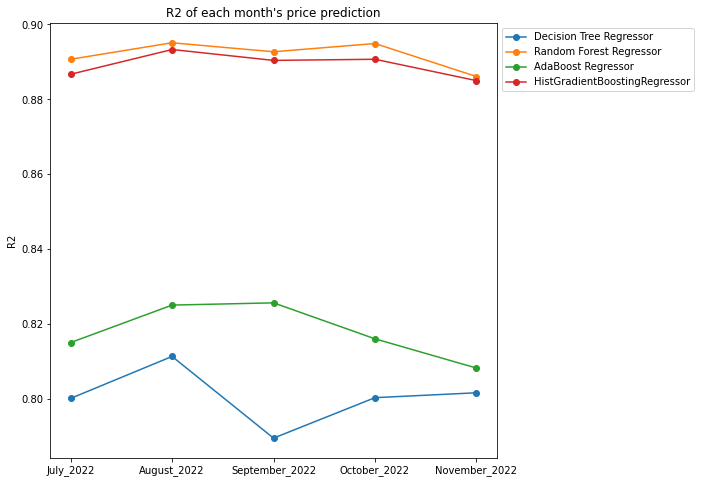

In [13]:
plt.figure(figsize = (8, 8))
#plt.plot(r2_df['LR'], '-o', label = 'Linear Regressor')
plt.plot(r2_df['DTR'], '-o', label = 'Decision Tree Regressor')
plt.plot(r2_df['RF'], '-o', label = 'Random Forest Regressor')
plt.plot(r2_df['ADA'], '-o', label = 'AdaBoost Regressor')
plt.plot(r2_df['HGBR'], '-o', label = 'HistGradientBoostingRegressor')
plt.title("R2 of each month's price prediction")
plt.ylabel('R2')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [14]:
rmse_df

,LR,DTR,RF,ADA,HGBR
July_2022,196284.4836,134934.3153,99776.8239,129831.7829,101601.4891
August_2022,118510.4617,127224.9875,94962.4788,122621.4026,95773.5062
September_2022,116135.6328,133170.2971,95002.3280,121150.4720,96048.7717
October_2022,118011.6136,130322.3877,94702.7379,125328.7479,96577.5173
November_2022,116935.6551,123325.5783,93738.5479,121545.4041,94177.5976


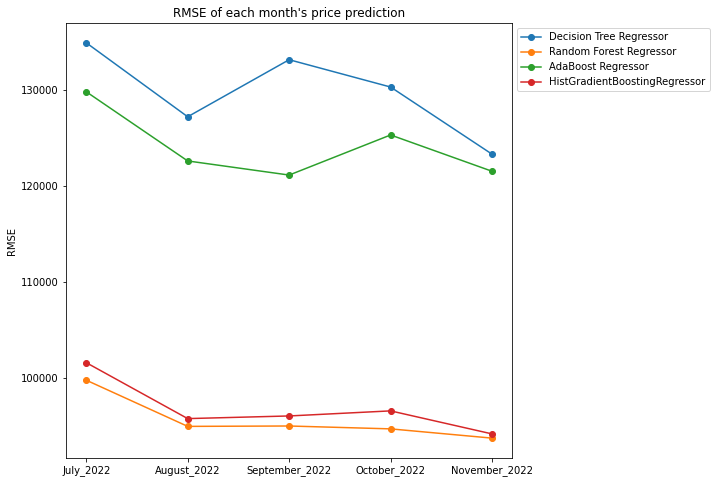

In [15]:
plt.figure(figsize = (8, 8))
plt.plot(rmse_df['DTR'], '-o', label = 'Decision Tree Regressor')
plt.plot(rmse_df['RF'], '-o', label = 'Random Forest Regressor')
plt.plot(rmse_df['ADA'], '-o', label = 'AdaBoost Regressor')
plt.plot(rmse_df['HGBR'], '-o', label = 'HistGradientBoostingRegressor')
plt.title("RMSE of each month's price prediction")
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Can we use boxcox to get better results?

In [16]:
##Let's try October 2022
df_Oct2022 = transformed_df_dict['October_2022'][features_t]
data = df_Oct2022.to_numpy()
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
cv.split(data)

test_r2_array = np.zeros((5, ))
test_RMSE_array = np.zeros((5, ))
test_MAE_array = np.zeros((5, ))

for i, (train_index, test_index) in enumerate(cv.split(data)):
    train_set = df_Oct2022.iloc[train_index].iloc[:, :-1].to_numpy()
    train_target = df_Oct2022.iloc[train_index].iloc[:, -1].to_numpy()
    test_set = df_Oct2022.iloc[test_index].iloc[:, :-1].to_numpy()
    test_target = df_Oct2022.iloc[test_index].iloc[:, -1].to_numpy()
    
    pt = PowerTransformer(method = 'box-cox')
    transformed_train_target = pt.fit_transform(train_target.copy().reshape(-1, 1)).ravel()
    transformed_test_target = pt.transform(test_target.copy().reshape(-1, 1)).ravel()
    HGBR = HistGradientBoostingRegressor(learning_rate = 0.2, random_state = 0)
    HGBR.fit(X = train_set, y = transformed_train_target)
    predicted_values = HGBR.predict(test_set)
    test_r2_array[i] = r2_score(test_target, pt.inverse_transform(predicted_values.reshape(-1, 1)).ravel())
    test_RMSE_array[i] = mean_squared_error(test_target, pt.inverse_transform(predicted_values.reshape(-1, 1)).ravel(), squared = False)
    test_MAE_array[i] = mean_absolute_error(test_target, pt.inverse_transform(predicted_values.reshape(-1, 1)).ravel())

In [17]:
##Based on the result the difference is not big enough to be noticed
print("OCT 2022 RESULTS:")
print("Mean test R2 score: ", np.round(np.mean(test_r2_array), 4))
print("Mean test RMSE score: ", np.round(np.mean(test_RMSE_array), 4))
print("Mean test MAE score: ", np.round(np.mean(test_MAE_array), 4))

OCT 2022 RESULTS:
Mean test R2 score:  0.8943
Mean test RMSE score:  94947.109
Mean test MAE score:  51233.6393


## Deep learning with Tensorflow

In [18]:
tf.random.set_seed(1234)

In [19]:
def ann_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(16)(i)
    x = Activation('relu')(x)
    x = Dense(16)(x)
    x = Activation('relu')(x)
    x = Dense(16)(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(16)(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.35)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [20]:
model1 = ann_generator(8)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0     

### Deep learning (All features are scaled into range 0-1)

In [49]:
df_Oct2022 = transformed_df_dict['October_2022'][features_t]
data = df_Oct2022.to_numpy()
n_folds = 5
cv = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
cv.split(data)
nums_of_epoch = 40
test_loss_array = np.zeros((n_folds, nums_of_epoch))
test_RMSE_array = np.zeros((n_folds, nums_of_epoch))

for i, (train_index, test_index) in enumerate(cv.split(data)):
    train_set = df_Oct2022.iloc[train_index].iloc[:, :-1].to_numpy().astype(np.float64)
    train_target = df_Oct2022.iloc[train_index].iloc[:, -1].to_numpy().astype(np.float64)
    test_set = df_Oct2022.iloc[test_index].iloc[:, :-1].to_numpy().astype(np.float64)
    test_target = df_Oct2022.iloc[test_index].iloc[:, -1].to_numpy().astype(np.float64)
    input_shape = train_set.shape[1]
    scaler = MinMaxScaler()
    pt = PowerTransformer(method = 'box-cox')
    
    ##Have to scale every features into range 0-1 
    transformed_train_set = scaler.fit_transform(train_set)
    transformed_test_set = scaler.transform(test_set)
    transformed_train_target = pt.fit_transform(train_target.copy().reshape(-1, 1)).ravel()
    transformed_test_target = pt.transform(test_target.copy().reshape(-1, 1)).ravel()
    
    model = ann_generator(input_shape)
    model.compile(loss = 'mse', optimizer = 'adam',  
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    r = model.fit(transformed_train_set, transformed_train_target, batch_size = 32, epochs = nums_of_epoch, verbose = 0,
                  validation_data = (transformed_test_set, transformed_test_target))
    test_loss_array[i, :] = r.history['loss']
    test_RMSE_array[i, :] = r.history['root_mean_squared_error']

In [53]:
###Build a table for both RMSE and loss
index_set = ['test_' + str(i) for i in range(n_folds)]
cols = ['epoch_' + str(i) for i in range(nums_of_epoch)]
loss_df = pd.DataFrame(test_loss_array, index = index_set, columns = cols)
rmse_df = pd.DataFrame(test_RMSE_array, index = index_set, columns = cols)

In [55]:
loss_df.transpose()

,test_0,test_1,test_2,test_3,test_4
epoch_0,1.168665,1.066710,0.890276,0.943643,0.886189
epoch_1,0.555730,0.565611,0.532167,0.560700,0.477723
epoch_2,0.450318,0.464657,0.456021,0.420406,0.420023
epoch_3,0.395738,0.405826,0.410344,0.370239,0.387995
epoch_4,0.364504,0.377149,0.376882,0.355718,0.367640
epoch_5,0.336917,0.355611,0.354222,0.330694,0.358508
epoch_6,0.326094,0.340710,0.355308,0.322030,0.346891
epoch_7,0.327296,0.341728,0.350690,0.313472,0.340637
epoch_8,0.317348,0.324793,0.341654,0.313082,0.330827
epoch_9,0.303781,0.322456,0.335821,0.305600,0.331161


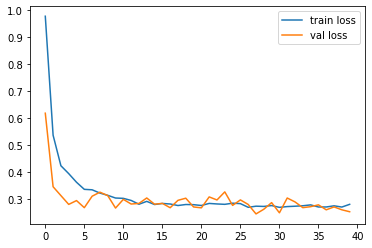

In [34]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend();

In [42]:
loss_matrix = np.zeros((1, len(r.history['loss'])))
loss_matrix[0, :] = r.history['loss']
cols = ['epoch_' + str(i) for i in range(len(r.history['loss']))]
cols

['epoch_0',
 'epoch_1',
 'epoch_2',
 'epoch_3',
 'epoch_4',
 'epoch_5',
 'epoch_6',
 'epoch_7',
 'epoch_8',
 'epoch_9',
 'epoch_10',
 'epoch_11',
 'epoch_12',
 'epoch_13',
 'epoch_14',
 'epoch_15',
 'epoch_16',
 'epoch_17',
 'epoch_18',
 'epoch_19',
 'epoch_20',
 'epoch_21',
 'epoch_22',
 'epoch_23',
 'epoch_24',
 'epoch_25',
 'epoch_26',
 'epoch_27',
 'epoch_28',
 'epoch_29',
 'epoch_30',
 'epoch_31',
 'epoch_32',
 'epoch_33',
 'epoch_34',
 'epoch_35',
 'epoch_36',
 'epoch_37',
 'epoch_38',
 'epoch_39']

In [43]:
loss_matrix

array([[0.97786748, 0.53772593, 0.42472345, 0.39556167, 0.36360282,
        0.33738831, 0.33571488, 0.32357398, 0.31524119, 0.30526441,
        0.30404535, 0.29633296, 0.2822485 , 0.29288477, 0.28122133,
        0.28523168, 0.28316435, 0.27749518, 0.28125533, 0.28066477,
        0.27762792, 0.28527173, 0.28332064, 0.28193143, 0.2861031 ,
        0.28453156, 0.2709125 , 0.27504611, 0.27418154, 0.2773256 ,
        0.27079782, 0.27360547, 0.27490798, 0.27662992, 0.27985209,
        0.2720606 , 0.27212781, 0.27643919, 0.27184129, 0.28191483]])

In [44]:
test11 = pd.DataFrame(loss_matrix, index = ['set_1'], columns = cols)

In [45]:
test11

,epoch_0,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,epoch_30,epoch_31,epoch_32,epoch_33,epoch_34,epoch_35,epoch_36,epoch_37,epoch_38,epoch_39
set_1,0.977867,0.537726,0.424723,0.395562,0.363603,0.337388,0.335715,0.323574,0.315241,0.305264,...,0.270798,0.273605,0.274908,0.27663,0.279852,0.272061,0.272128,0.276439,0.271841,0.281915


### Deep learning (unequally scaled features)